In [1]:
from os import listdir
import os, random, copy
from PIL import Image
import numpy as np
from collections import defaultdict
import pandas as pd

In [2]:
# -*- coding: utf-8 -*-
"""
Created on Tue Jan 14 22:43:07 2020

@author: james 

Utilizes functions from dataloader.py given in the PA1.zip file. Will utilize PCA...
"""
from os import listdir
import os, random, copy
from PIL import Image
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

''' 
list of face expressions (contempt, neutral are excluded) are:
1. anger
2. disgust
3. fear
4. happiness
5. sadness
6. surprise
'''

def load_data(data_dir="./aligned/"):
	""" Load all PNG images stored in your data directory into a list of NumPy
	arrays.

	Args:
		data_dir: The relative directory path to the CK+ image directory.
	Returns:
		images: A dictionary with keys as emotions and a list containing images associated with each key.
		cnt: A dictionary that stores the # of images in each emotion
	"""
	images = defaultdict(list)

	# Get the list of emotional directory:
	for e in listdir(data_dir):
		# excluding any non-directory files
		if not os.path.isdir(os.path.join(data_dir, e)):
			continue
		# Get the list of image file names
		all_files = listdir(os.path.join(data_dir, e))

		for file in all_files:
			# Load only image files as PIL images and convert to NumPy arrays
			if '.png' in file:
				img = Image.open(os.path.join(data_dir, e, file))
				images[e].append(np.array(img))

	print("Emotions: {} \n".format(list(images.keys())))

	cnt = defaultdict(int)
	for e in images.keys():
		print("{}: {} # of images".format(e, len(images[e])))
		cnt[e] = len(images[e])
	return images, cnt

def balanced_sampler(dataset, cnt, emotions):
	# this ensures everyone has the same balanced subset for model training, don't change this seed value
	random.seed(20)
	print("\nBalanced Set:")
	min_cnt = min([cnt[e] for e in emotions])
	balanced_subset = defaultdict(list)
	for e in emotions:
		balanced_subset[e] = copy.deepcopy(dataset[e])
		random.shuffle(balanced_subset[e])
		balanced_subset[e] = balanced_subset[e][:min_cnt]
		print('{}: {} # of images'.format(e, len(balanced_subset[e])))
	return balanced_subset

def display_face(img):
	""" Display the input image and optionally save as a PNG.

	Args:
		img: The NumPy array or image to display

	Returns: None
	"""
	# Convert img to PIL Image object (if it's an ndarray)
	if type(img) == np.ndarray:
		print("Converting from array to PIL Image")
		img = Image.fromarray(img)

	# Display the image
	img.show()



def CheckMutuallyExclusive(areMutuallyExclusive):
    for k,v in areMutuallyExclusive.items():
        #within a fold:
        for i in range(len(v)):
            toBeEvaluated = v[i]
            for j in range(i+1, len(v)):
                if(np.array_equal(toBeEvaluated,v[j])):
                    print("Well this sucks I have redundancies within a fold...")
        #between folds:
        for key,value in areMutuallyExclusive.items():
            if k == key:
                continue
            else:
                for i in range(len(v)):
                    for j in range(len(value)):
                        if np.array_equal(v[i], value[j]):
                            print("Son of a.... there are redundancies between folds")
                    
    return None 

#PCA:
    
# Function to convert the Python dictionary loaded in by the dataloader.py load_data function 
# into a NumPy matrix for downstream manipulation
# Params:
# image_dict - Python dictionary with facial expressions as keys and a list NumPy arrays representing
#              image as values
# Return: A NumPy matrix of dimensions dxM denoting M images of d dimensions and the corresponding targets
def get_matrix(image_dict):
    #forTargets = 0
    #correspondingTargets = []
    image_matrix = []
    for emotion in image_dict:
        for image in image_dict[emotion]:
            image_matrix.append(np.concatenate(image))
            #correspondingTargets.append(forTargets)
        #forTargets += 1
    return np.matrix(image_matrix).T #, correspondingTargets

# Function to apply PCA to a dxM image matrix, with M images each of dimension d
# Params:
# image_matrix - a dxM matrix representing M images each of dimension d (output of get_matrix)
# Return: the eigenvalues and principal components of the covariance matrix of the input
# eig_vals - the M eigenvalues of the MxM covariance matrix
# pcs - the M dx1 eigenvectors of the covariance matrix in the form of a dxM matrix
# Return: the M eigenvalues and M pcs from the covariance matrix calculated via PCA
def principal_components(image_matrix):
    mean_face = np.matrix.mean(image_matrix, axis = 1)
    centered_matrix = image_matrix - mean_face
    covariance_matrix = np.dot(centered_matrix.T, centered_matrix)/centered_matrix.shape[1]
    eig_vals, eig_vecs = np.linalg.eig(covariance_matrix)
    order = np.argsort(eig_vals)[::-1]
    eig_vals = eig_vals[order]
    eig_vecs = eig_vecs[:,order]
    pcs = centered_matrix*eig_vecs
    return(eig_vals, pcs)
    
# Function to project a dxM image matrix onto pcs calculate by PCA
# Params:
# mean_face - the average face calculate from averaging pixel values of training set
# image_matrix - the images to project in the from of a dxM matrix
# eig_vals - the eigenvalues calculated from PCA on the training set
# pcs - the pcs calculated from PCA on the training set
# k - the number of dimensions to keep
# Return: the dxM image matrix projected down to the kxM space
def project_k_dimensions(mean_face, image_matrix, eig_vals, pcs, k):
    centered_matrix = image_matrix - mean_face
    projections = centered_matrix.T*pcs[:, 0:k]
    projections = projections/(np.linalg.norm(pcs[:, 0:k], axis = 0))/np.sqrt(eig_vals[0:k])
    return projections.T#[:,0:k].T

#LOGISTIC REGRESSION FUNCTIONS:

#INPUT: List of numpy arrays
#OUTPUT: list of flattened numpy arrays with a 1 to account for bias at the front 
def Transform(aSeriesOfUnfortunateEvents): #Flatten the  numpy arrays and add a bias term to the front
    countOlaf = list()
    for baudelaire in aSeriesOfUnfortunateEvents:
        countOlaf.append(np.concatenate((np.array([1]),baudelaire.flatten())))
    return countOlaf 

def MatrixToListOfTransformedArrays(annoyingMatrix):
    return list(np.squeeze(np.asarray(annoyingMatrix)))


In [3]:
def load_data(data_dir="./aligned/"):
	""" Load all PNG images stored in your data directory into a list of NumPy
	arrays.

	Args:
		data_dir: The relative directory path to the CK+ image directory.
	Returns:
		images: A dictionary with keys as emotions and a list containing images associated with each key.
		cnt: A dictionary that stores the # of images in each emotion
	"""
	images = defaultdict(list)

	# Get the list of emotional directory:
	for e in listdir(data_dir):
		# excluding any non-directory files
		if not os.path.isdir(os.path.join(data_dir, e)):
			continue
		# Get the list of image file names
		all_files = listdir(os.path.join(data_dir, e))

		for file in all_files:
			# Load only image files as PIL images and convert to NumPy arrays
			if '.png' in file:
				img = Image.open(os.path.join(data_dir, e, file))
				images[e].append(np.array(img))

	print("Emotions: {} \n".format(list(images.keys())))

	cnt = defaultdict(int)
	for e in images.keys():
		print("{}: {} # of images".format(e, len(images[e])))
		cnt[e] = len(images[e])
	return images, cnt

def balanced_sampler(dataset, cnt, emotions):
	# this ensures everyone has the same balanced subset for model training, don't change this seed value
	random.seed(20)
	print("\nBalanced Set:")
	min_cnt = min([cnt[e] for e in emotions])
	balanced_subset = defaultdict(list)
	for e in emotions:
		balanced_subset[e] = copy.deepcopy(dataset[e])
		random.shuffle(balanced_subset[e])
		balanced_subset[e] = balanced_subset[e][:min_cnt]
		print('{}: {} # of images'.format(e, len(balanced_subset[e])))
	return balanced_subset

def display_face(img):
	""" Display the input image and optionally save as a PNG.

	Args:
		img: The NumPy array or image to display

	Returns: None
	"""
	# Convert img to PIL Image object (if it's an ndarray)
	if type(img) == np.ndarray:
		print("Converting from array to PIL Image")
		img = Image.fromarray(img)

	# Display the image
	img.show()

In [4]:
# example on how to use it
if __name__ == '__main__':
	# The relative path to your image directory
	data_dir = "./PA1/aligned/"
	dataset, cnt = load_data(data_dir)
	# test with happiness and anger
	images = balanced_sampler(dataset, cnt, emotions=['happiness', 'anger',"fear","surprise","sadness","disgust"] )
	display_index = 0
	display_face(images['anger'][display_index])

Emotions: ['fear', 'surprise', 'sadness', 'happiness', 'anger', 'disgust'] 

fear: 25 # of images
surprise: 83 # of images
sadness: 28 # of images
happiness: 69 # of images
anger: 45 # of images
disgust: 59 # of images

Balanced Set:
happiness: 25 # of images
anger: 25 # of images
fear: 25 # of images
surprise: 25 # of images
sadness: 25 # of images
disgust: 25 # of images
Converting from array to PIL Image


In [5]:
#get image categories
images.keys()
#map categories to numeric categories
d = dict([(y,x) for x,y in enumerate(sorted(set(images.keys())))])

In [81]:
#one-hot encoding of y target
def one_hot(y):
    y=np.array(y)
    y_ = np.zeros((y.size, y.max()+1))
    y_[np.arange(y.size),y] = 1
    return(y_)

In [92]:
[random.shuffle(v) for k,v in images.items()]

[None, None, None, None, None, None]

In [96]:
[v for k,v in images.items()]

[[array([[28, 28, 27, ..., 45, 43, 42],
         [28, 28, 28, ..., 44, 44, 43],
         [28, 28, 29, ..., 42, 42, 41],
         ...,
         [23, 23, 24, ..., 12, 14, 18],
         [22, 23, 25, ..., 14, 15, 16],
         [24, 24, 21, ..., 15, 17, 19]], dtype=uint8),
  array([[ 0,  0,  0, ..., 66, 66, 66],
         [ 0,  0,  0, ..., 67, 68, 68],
         [ 0,  0,  0, ..., 69, 70, 70],
         ...,
         [46, 46, 46, ..., 55, 56, 56],
         [44, 44, 44, ..., 56, 56, 56],
         [45, 45, 46, ..., 53, 54, 54]], dtype=uint8),
  array([[156, 132, 118, ..., 255, 255, 255],
         [156, 139, 126, ..., 254, 255, 255],
         [160, 146, 138, ..., 254, 254, 255],
         ...,
         [ 17,  28,  40, ...,   8,   8,   7],
         [ 17,  28,  38, ...,   7,   7,   8],
         [ 15,  26,  39, ...,   8,   8,   8]], dtype=uint8),
  array([[36, 36, 33, ...,  3,  2,  3],
         [35, 34, 30, ...,  5,  3,  5],
         [37, 35, 32, ...,  2,  3,  1],
         ...,
         [46, 48, 46, .

In [97]:
#INPUT: images and number of k mutually exclusive sets
#OUTPUT: dictionary of k mutually exclusive sets with roughly same number of each category
def CrossFold(dataset,number):
    toReturn = defaultdict(list)
    targets = defaultdict(list)

    image_total=[]
    label_total=[]
    
    labels =[k for k,v in dataset.items()]
    numimages=len([x for x in dataset.values()][0])
    for i in range(numimages):
        for x in labels:
            image_total.append(dataset[x][i])
            label_total.append(x)
    image_split=np.array_split(image_total,number)
    label_split=np.array_split(label_total,number)

    for i in range(len(image_split)):
        toReturn[i]=image_split[i]
        targets[i]=[d[x] for x in label_split[i]]
    return toReturn,targets

In [94]:
split, labels = CrossFold(images,10)

In [95]:
split[9]

array([[[ 50,  51,  51, ...,  61,  62,  61],
        [ 51,  51,  51, ...,  60,  59,  58],
        [ 52,  52,  52, ...,  60,  58,  58],
        ...,
        [ 64, 117, 168, ...,  48,  49,  47],
        [153, 177, 186, ...,  47,  49,  47],
        [181, 183, 183, ...,  46,  49,  47]],

       [[225, 222, 222, ..., 217, 216, 217],
        [224, 222, 222, ..., 219, 219, 219],
        [226, 225, 223, ..., 217, 219, 219],
        ...,
        [ 82,  85,  76, ...,  64,  70,  73],
        [ 89,  88,  78, ...,  61,  70,  78],
        [ 89,  84,  81, ...,  61,  69,  79]],

       [[ 97, 100, 100, ..., 117, 118, 118],
        [ 97,  99, 100, ..., 119, 121, 120],
        [ 96,  98,  98, ..., 118, 119, 118],
        ...,
        [ 64,  66,  65, ...,  63,  68,  67],
        [ 64,  63,  64, ...,  66,  71,  72],
        [ 64,  64,  64, ...,  87,  70,  65]],

       ...,

       [[123, 124, 125, ..., 156, 157, 160],
        [121, 121, 124, ..., 159, 158, 159],
        [121, 123, 127, ..., 156, 155, 156

In [10]:
CheckMutuallyExclusive(split)

In [11]:
trainData = defaultdict(list)
trainLabels = []
valData = defaultdict(list)
valLabels = []
testData = defaultdict(list)
testLabels = []

counter = 0 

for k,v in split.items():
    if counter < 8:
        for vals in v:
            trainData["train"].append(vals)
        for l in labels[k]:
            trainLabels.append(l)
        counter += 1
    elif (counter == 8):
        for vals in v:
            valData["val"].append(vals)
        for l in labels[k]:
            valLabels.append(l)
        counter += 1 
    else: 
        for vals in v:
            testData["test"].append(vals)
        for l in labels[k]:
            testLabels.append(l)
    

In [12]:
trainLabels=one_hot(trainLabels)
valLabels=one_hot(valLabels)
testLabels=one_hot(testLabels)

In [13]:
len(trainLabels.T)

6

In [14]:
print(len(trainData["train"])/len([val for k,v in split.items() for val in v]))
print(len(valData["val"])/len([val for k,v in split.items() for val in v]))
print(len(testData["test"])/len([val for k,v in split.items() for val in v]))

0.8
0.1
0.1


In [15]:
trainingMatrix = get_matrix(trainData)
eig_vals, pcs = principal_components(trainingMatrix)
mean_face = np.matrix.mean(trainingMatrix, axis = 1)
centered_matrix = trainingMatrix - mean_face

In [16]:
howManyPrincipalComponents=40

In [17]:
projectedTrain = project_k_dimensions(mean_face, trainingMatrix, eig_vals, pcs, howManyPrincipalComponents).T
projectedTrain = Transform(MatrixToListOfTransformedArrays(projectedTrain))
projectedVal = project_k_dimensions(mean_face, get_matrix(valData), eig_vals, pcs, howManyPrincipalComponents).T
projectedVal = Transform(MatrixToListOfTransformedArrays(projectedVal))
projectedTest = project_k_dimensions(mean_face, get_matrix(testData), eig_vals, pcs, howManyPrincipalComponents).T
projectedTest = Transform(MatrixToListOfTransformedArrays(projectedTest))

In [18]:
projectedTrain=np.array(projectedTrain)
projectedVal=np.array(projectedVal)
projectedTest=np.array(projectedTest)

## Batch Gradient Descent

In [19]:
#define number of inputs and outputs
num_inputs=howManyPrincipalComponents
num_outputs=6

In [20]:
#define net input of matrix which is dot product of feature matrix and weights
def net_input(X, W):
    return (X.dot(W))

In [21]:
#define softmax function
def softmax(z):
    return (np.exp(z.T) / np.sum(np.exp(z), axis=1)).T

In [22]:
#define functions to convert to class labels
def to_classlabel(z):
    return z.argmax(axis=1)

In [23]:
def cross_entropy(output, y_target):
    return - np.sum(np.log(output) * (y_target),axis=1)

In [24]:
def cost(output, y_target):
    return np.sum(cross_entropy(output, y_target))

In [25]:
def ComputeSigmoidFunction(func):
    if type(func) is np.ndarray:
        func = func[0]
    return 1/(1 + np.exp(-1 * func))

In [26]:
def accuracy(pred, actual):
    count=0
    for x in range(len(pred)):
        if to_classlabel(pred)[x]==to_classlabel(actual)[x]:
            count+=1
        else: pass
    return(count/len(pred))

In [189]:
W.shape

(41, 6)

In [218]:
def class_gradient(xtrain,ytrain,w,xvalid,yvalid,learningrate,iterations):
    train_cost_hx= np.zeros(iterations)
    valid_cost_hx=np.zeros(iterations)
    train_acc_hx=np.zeros(iterations)
    valid_acc_hx=np.zeros(iterations)
    for j in range(iterations): 
        for i in range(len(w.T)):
            pred=(np.dot(xtrain,w.T[i]))
            w.T[i]-=(1/len(xtrain))*learningrate*(xtrain.T.dot((pred-ytrain.T[i])))
        train_cost_hx[j]=(cost(softmax(net_input(xtrain,W)),np.array(ytrain)))/len(xtrain)
        valid_cost_hx[j]=(cost(softmax(net_input(xvalid,W)),np.array(yvalid)))/len(xvalid)
        train_acc_hx[j]=accuracy(softmax(net_input(xtrain,W)),ytrain)
        valid_acc_hx[j]=accuracy(softmax(net_input(xvalid,W)),yvalid)
        print((w))
    return w,train_cost_hx,valid_cost_hx,train_acc_hx,valid_acc_hx
        
        
        

In [219]:
W = np.zeros((num_inputs+1, num_outputs))
trainedW,trainlosses,validlosses,train_acc,valid_acc=class_gradient(projectedTrain,trainLabels,W,projectedVal,valLabels,0.3,50)


[[ 5.00000000e-02  5.00000000e-02  5.00000000e-02  5.00000000e-02
   5.00000000e-02  5.00000000e-02]
 [-1.46771795e-02  5.79699489e-03  1.50234263e-02 -1.51608645e-02
   7.37399260e-03  1.64363022e-03]
 [-1.30301332e-02  1.22899124e-02 -3.45596429e-03 -2.73119292e-03
  -6.73776370e-03  1.36651417e-02]
 [-7.19042670e-03 -3.29118751e-02  2.40051780e-02 -1.81625092e-02
   9.74495363e-03  2.45146793e-02]
 [-5.11079288e-03 -2.32052869e-02  6.85382880e-03 -4.89280286e-02
   5.01992330e-03  6.53703562e-02]
 [ 1.03495565e-02 -6.93037124e-03 -3.49344058e-02 -2.30883825e-02
   3.69403905e-02  1.76632125e-02]
 [-1.76830813e-04  8.16246929e-03 -2.33339612e-02 -1.73310451e-02
   1.05151498e-03  3.16278528e-02]
 [-2.47004038e-02 -1.45601426e-02  3.39767917e-02  2.35550581e-02
  -2.39521304e-02  5.68082694e-03]
 [ 6.52228761e-03  1.22474492e-02 -1.85559645e-02  2.50090755e-02
  -1.82973880e-02 -6.92545971e-03]
 [ 2.77508187e-02 -1.12079467e-02  8.83442487e-03 -2.88177106e-03
   9.78961458e-03 -3.2285

In [220]:
trainlosses

array([1.6128446 , 1.49369272, 1.4135102 , 1.3590392 , 1.32174573,
       1.29605782, 1.27828336, 1.26594352, 1.25735601, 1.25136953,
       1.24719117, 1.24427229, 1.242232  , 1.24080524, 1.23980721,
       1.23910893, 1.23862031, 1.23827836, 1.23803903, 1.23787152,
       1.23775428, 1.23767221, 1.23761476, 1.23757455, 1.23754641,
       1.2375267 , 1.23751291, 1.23750326, 1.2374965 , 1.23749177,
       1.23748846, 1.23748614, 1.23748452, 1.23748338, 1.23748259,
       1.23748203, 1.23748164, 1.23748137, 1.23748118, 1.23748104,
       1.23748095, 1.23748088, 1.23748084, 1.23748081, 1.23748078,
       1.23748077, 1.23748076, 1.23748075, 1.23748074, 1.23748074])

## 6ai. Plot loss on training set and holdout set for 1 run

Text(0.5, 1.0, 'Loss on training set and holdout set vs. number of epochs of gradient descent')

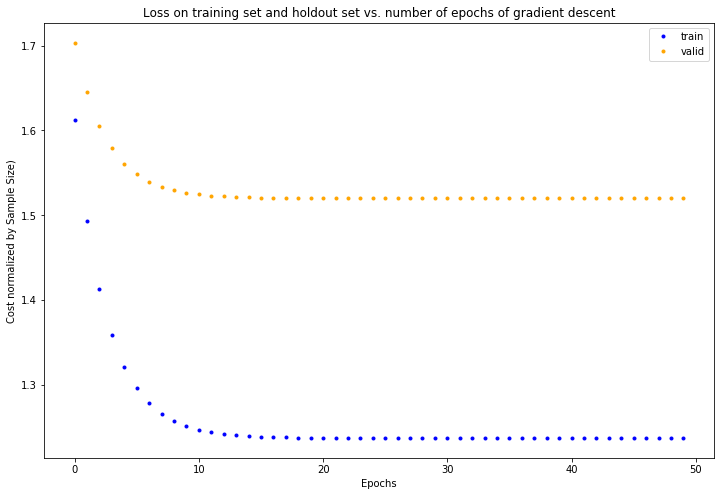

In [221]:
fig,ax = plt.subplots(figsize=(12,8))
ax.set_ylabel('Cost normalized by Sample Size)')
ax.set_xlabel('Epochs')
_=ax.plot(range(50),trainlosses,'b.',color="blue",label="train")
_=ax.plot(range(50),validlosses,'b.',color="orange",label="valid")
plt.legend()
plt.title("Loss on training set and holdout set vs. number of epochs of gradient descent")

## 6ai. Plot loss on training set and holdout set with different subject for test set

In [223]:
def run_gradient_descent(numruns,principalcomponents):
    total=[]
    dataset, cnt = load_data("./PA1/aligned/")
    images = balanced_sampler(dataset, cnt, emotions=['happiness', 'anger',"fear","surprise","sadness","disgust"])
    
    for p in range(numruns):
        ##randomly shuffle data to get new test set images##
        [random.shuffle(v) for k,v in images.items()]
        ##Cross fold to get 10 mututally exclusive set##
        split, labels = CrossFold(images,10)
        CheckMutuallyExclusive(split)
        
        ##Split into training, validation and test data###
        trainData = defaultdict(list)
        trainLabels = []
        valData = defaultdict(list)
        valLabels = []
        testData = defaultdict(list)
        testLabels = []
        
        counter = 0 

        for k,v in split.items():
            if counter < 8:
                for vals in v:
                    trainData["train"].append(vals)
                for l in labels[k]:
                    trainLabels.append(l)
                counter += 1
            elif (counter == 8):
                for vals in v:
                    valData["val"].append(vals)
                for l in labels[k]:
                    valLabels.append(l)
                counter += 1 
            else: 
                for vals in v:
                    testData["test"].append(vals)
                for l in labels[k]:
                    testLabels.append(l)
        print(len(trainData["train"])/len([val for k,v in split.items() for val in v]))
        print(len(valData["val"])/len([val for k,v in split.items() for val in v]))
        print(len(testData["test"])/len([val for k,v in split.items() for val in v]))
        
        ##one-hot encode labels##
        trainLabels=one_hot(trainLabels)
        valLabels=one_hot(valLabels)
        testLabels=one_hot(np.array(testLabels))
        
        ##Create X feature matrix based on PCs Principal Components##
        
        trainingMatrix = get_matrix(trainData)
        eig_vals, pcs = principal_components(trainingMatrix)
        mean_face = np.matrix.mean(trainingMatrix, axis = 1)
        centered_matrix = trainingMatrix - mean_face
        
        howManyPrincipalComponents=principalcomponents
        
        projectedTrain = project_k_dimensions(mean_face, trainingMatrix, eig_vals, pcs, howManyPrincipalComponents).T
        projectedTrain = Transform(MatrixToListOfTransformedArrays(projectedTrain))
        projectedVal = project_k_dimensions(mean_face, get_matrix(valData), eig_vals, pcs, howManyPrincipalComponents).T
        projectedVal = Transform(MatrixToListOfTransformedArrays(projectedVal))
        projectedTest = project_k_dimensions(mean_face, get_matrix(testData), eig_vals, pcs, howManyPrincipalComponents).T
        projectedTest = Transform(MatrixToListOfTransformedArrays(projectedTest))
        
        projectedTrain=np.array(projectedTrain)
        projectedVal=np.array(projectedVal)
        projectedTest=np.array(projectedTest)
        
        num_inputs=howManyPrincipalComponents
        num_outputs=len(trainLabels.T)
        
        print(projectedTrain.shape)
        W = np.zeros((principalcomponents+1, 6))
        W,trainlosses,validlosses,train_acc,valid_acc=class_gradient(projectedTrain,trainLabels,W,projectedVal,valLabels,0.1,2)
        total.append(trainlosses)
    return(total)
        
    

In [224]:
run_gradient_descent(10,40)

Emotions: ['fear', 'surprise', 'sadness', 'happiness', 'anger', 'disgust'] 

fear: 25 # of images
surprise: 83 # of images
sadness: 28 # of images
happiness: 69 # of images
anger: 45 # of images
disgust: 59 # of images

Balanced Set:
happiness: 25 # of images
anger: 25 # of images
fear: 25 # of images
surprise: 25 # of images
sadness: 25 # of images
disgust: 25 # of images
0.8
0.1
0.1
(120, 41)
[[ 1.66666667e-02  1.66666667e-02  1.66666667e-02  1.66666667e-02
   1.66666667e-02  1.66666667e-02]
 [-1.71296128e-03  1.75212285e-03  2.85176202e-03 -7.79589926e-03
   3.01080101e-03  1.89417465e-03]
 [-1.80420910e-03  4.21910040e-03 -4.70466882e-03 -3.04352999e-04
  -3.67506839e-03  6.26919891e-03]
 [-5.85848467e-03 -6.65782162e-03  5.47156011e-03 -8.49737889e-03
   4.83789513e-03  1.07042299e-02]
 [ 9.38025421e-04  9.10450905e-03 -2.76668103e-03  1.33651701e-02
  -4.44454956e-03 -1.61964740e-02]
 [ 2.94994215e-04  3.72964528e-04 -4.46313035e-03 -8.90122992e-03
   4.71246182e-03  7.98393971e-

0.8
0.1
0.1
(120, 41)
[[ 1.66666667e-02  1.66666667e-02  1.66666667e-02  1.66666667e-02
   1.66666667e-02  1.66666667e-02]
 [-7.35415075e-04 -1.63334611e-03 -1.62052000e-03  6.43690959e-03
  -2.69604695e-03  2.48418548e-04]
 [-2.96512084e-03  3.90346905e-03 -1.93867792e-03 -9.05623346e-04
  -3.40543154e-03  5.31138460e-03]
 [-4.17207395e-03 -8.96236194e-03  5.35524516e-03 -1.06371415e-02
   5.41642852e-03  1.29999037e-02]
 [ 5.36238573e-04  5.90241003e-03 -1.39077954e-03  1.40901336e-02
  -1.62507498e-03 -1.75129277e-02]
 [-3.77270918e-03 -3.41657286e-04  6.66930854e-03  1.12707884e-02
  -8.71269973e-03 -5.11303072e-03]
 [ 6.91619620e-03 -5.38855187e-04 -6.10646503e-03 -4.77830341e-03
   5.34643639e-03 -8.39008974e-04]
 [ 4.59761147e-05 -2.50403974e-03  1.57306066e-02  4.55834489e-03
  -5.01258151e-03 -1.28183063e-02]
 [ 1.17597752e-03  4.29672757e-03 -6.46194309e-03  8.19688569e-03
  -4.84070642e-03 -2.36694128e-03]
 [ 5.46527983e-03 -5.89698140e-03  2.59436166e-03  1.49473107e-03
  -

0.8
0.1
0.1
(120, 41)
[[ 1.66666667e-02  1.66666667e-02  1.66666667e-02  1.66666667e-02
   1.66666667e-02  1.66666667e-02]
 [-4.31004473e-04  7.50733041e-04  3.02046487e-03 -5.26540938e-03
  -7.50414641e-04  2.67563058e-03]
 [-4.75561040e-03  1.39425226e-03  1.42940121e-04 -2.44870482e-03
   3.59273151e-04  5.30784968e-03]
 [-1.37752540e-03 -8.87080672e-03  4.85473138e-03 -5.03242185e-03
   4.42524764e-03  6.00077495e-03]
 [-1.16270411e-03 -7.35815621e-03  1.89788617e-03 -1.57191556e-02
   4.23068122e-03  1.81114485e-02]
 [ 2.48978509e-03 -2.04570571e-04 -9.51315188e-03 -1.09636424e-02
   9.43285450e-03  8.75872522e-03]
 [ 1.52284955e-03  4.94173374e-03 -5.18653341e-03 -1.04829280e-02
   1.73493781e-03  7.46994032e-03]
 [-4.27598418e-03  1.25184474e-03  1.19366287e-02  1.63104798e-03
  -5.09684427e-03 -5.44669301e-03]
 [ 9.49219313e-03  7.86276458e-03 -4.04906923e-03 -2.45839832e-03
   2.33885664e-03 -1.31863468e-02]
 [ 1.11823572e-02  2.02761587e-03  4.82332447e-03 -1.50030395e-02
   

0.8
0.1
0.1
(120, 41)
[[ 1.66666667e-02  1.66666667e-02  1.66666667e-02  1.66666667e-02
   1.66666667e-02  1.66666667e-02]
 [-3.28937240e-03  4.92047785e-04  1.61032794e-03 -6.51830470e-03
   5.36634824e-03  2.33895313e-03]
 [-4.56493519e-03  1.25870601e-03  1.03740528e-03 -4.12134272e-03
  -1.15299692e-03  7.54316354e-03]
 [ 5.44191827e-04  7.73756230e-03 -6.35214823e-03  6.96983818e-03
  -3.74403545e-03 -5.15540862e-03]
 [ 4.31215446e-04  1.02351239e-02 -1.53017444e-03  1.52888338e-02
  -4.54933221e-03 -1.98756665e-02]
 [ 3.03665916e-03  3.53363345e-03 -9.24529369e-03 -1.02172730e-02
   6.79136582e-03  6.10090830e-03]
 [ 8.88480702e-03 -1.14243171e-03 -6.95577905e-03  1.54692427e-04
   6.43329346e-03 -7.37458214e-03]
 [ 6.66610608e-03  2.96253302e-03 -1.31500434e-02 -7.55844892e-03
   4.19557563e-03  6.88427757e-03]
 [ 8.17154173e-03  4.13062414e-03  2.45225853e-04 -4.93825025e-04
  -1.38644684e-03 -1.06671199e-02]
 [ 2.50632175e-03 -5.78038944e-03  6.85784417e-03 -6.81424834e-03
   

0.8
0.1
0.1
(120, 41)
[[ 1.66666667e-02  1.66666667e-02  1.66666667e-02  1.66666667e-02
   1.66666667e-02  1.66666667e-02]
 [ 1.79562605e-03 -3.09378157e-03 -2.61302700e-03  8.97071983e-03
  -1.95044535e-03 -3.10909195e-03]
 [-3.86308621e-03  4.93714865e-03 -2.55082818e-03  2.66297760e-03
  -3.77213687e-03  2.58592500e-03]
 [-4.52699395e-03 -5.37579500e-03  6.50107423e-03 -6.17976697e-03
   3.52772311e-03  6.05375858e-03]
 [-2.19320084e-04 -7.46349382e-03  2.67853722e-04 -1.77086090e-02
   3.33437824e-03  2.17891910e-02]
 [ 2.26125306e-03 -3.48248177e-04 -2.38407799e-03 -6.57671926e-03
   5.32223572e-03  1.72555666e-03]
 [-4.67875639e-04 -1.85149458e-03  1.45701199e-02  6.07808568e-03
  -5.48496316e-03 -1.28438722e-02]
 [ 9.78690745e-03 -6.95387879e-04 -8.43344036e-03 -7.38692941e-03
   9.35735596e-03 -2.62850576e-03]
 [-9.78271220e-03 -9.78023129e-03  6.40119566e-03  4.85209797e-03
  -1.15051928e-03  9.46016913e-03]
 [-9.12255916e-03  2.07680703e-03 -1.04274858e-03  3.89625698e-03
  -

0.8
0.1
0.1
(120, 41)
[[ 1.66666667e-02  1.66666667e-02  1.66666667e-02  1.66666667e-02
   1.66666667e-02  1.66666667e-02]
 [-9.04051830e-04  2.75097390e-03  1.67839186e-03 -6.85649637e-03
   7.76174992e-04  2.55500744e-03]
 [ 4.43121758e-03 -2.02595964e-03  1.56102735e-03  9.93922631e-04
   2.71669954e-03 -7.67690746e-03]
 [ 6.22655847e-03  6.09744083e-03 -6.11748499e-03  5.42525627e-03
  -3.08537374e-03 -8.54639685e-03]
 [-2.09969537e-04  8.85711948e-03 -6.59528548e-04  1.60644487e-02
  -6.38877560e-03 -1.76632945e-02]
 [ 6.92364967e-04  4.80322247e-04 -5.78019482e-03 -7.35312290e-03
   3.58583512e-03  8.37479539e-03]
 [-1.03930650e-02  8.78894775e-05  1.39572267e-02  7.84591844e-03
  -7.58113781e-03 -3.91683188e-03]
 [-2.42437517e-03  3.57861739e-03 -8.35704984e-03 -5.13017966e-03
   4.90953217e-03  7.42345510e-03]
 [ 6.69392819e-03  5.87184336e-03 -6.09023544e-03  2.94088725e-03
  -3.27976163e-04 -9.08844719e-03]
 [-9.08985892e-03 -4.17964689e-03 -5.65020194e-03  1.54054103e-02
  -

0.8
0.1
0.1
(120, 41)
[[ 1.66666667e-02  1.66666667e-02  1.66666667e-02  1.66666667e-02
   1.66666667e-02  1.66666667e-02]
 [-2.30640807e-03  7.89547801e-04  1.79820234e-03 -5.94068029e-03
   2.70007321e-03  2.95926500e-03]
 [ 6.48450676e-03 -5.89027730e-03  1.77501026e-03 -2.90508194e-04
   3.46143549e-03 -5.54016702e-03]
 [ 1.53060160e-03  7.23854324e-03 -6.43851002e-03  7.28543850e-03
  -1.00450872e-03 -8.61156460e-03]
 [-4.76536395e-04 -7.56339674e-03  7.41819489e-04 -1.65122312e-02
   3.27196436e-03  2.05383805e-02]
 [ 2.08285188e-03  2.38660802e-03 -7.47315838e-03 -6.75206348e-03
   8.73502549e-03  1.02073647e-03]
 [ 4.76665113e-04  1.11861590e-03 -3.63523462e-03 -5.91580526e-03
   3.45813599e-04  7.60994527e-03]
 [-5.72620387e-03 -1.73581233e-03  1.52817326e-02  4.03155514e-03
  -7.38186572e-03 -4.46940577e-03]
 [ 6.04878725e-03  5.86063929e-03 -3.84243799e-04  2.76461121e-03
  -5.34230633e-03 -8.94748761e-03]
 [-9.53027423e-03  2.93050668e-04 -5.19848564e-03  1.59856755e-02
  -

0.8
0.1
0.1
(120, 41)
[[ 1.66666667e-02  1.66666667e-02  1.66666667e-02  1.66666667e-02
   1.66666667e-02  1.66666667e-02]
 [ 1.87503529e-03  3.35734664e-04  4.10928008e-04  4.83099773e-03
  -4.30553615e-03 -3.14715954e-03]
 [ 9.22504350e-03 -5.40053164e-03 -3.71795691e-03 -2.15424372e-03
   7.18334575e-03 -5.13565699e-03]
 [ 2.10333690e-03  5.88366812e-03 -4.05339224e-03  2.76392803e-03
  -2.69567227e-03 -4.00186854e-03]
 [ 1.78357193e-03  8.35625940e-03 -1.48591171e-03  1.68028294e-02
  -5.59868412e-03 -1.98580649e-02]
 [ 1.83698626e-03 -7.57642860e-04 -3.86050530e-03 -1.03711180e-02
   5.76198627e-03  7.39029364e-03]
 [ 6.97664164e-03  3.56924661e-03 -1.48678831e-02 -7.74669642e-03
   6.73629398e-03  5.33239726e-03]
 [ 3.39643130e-03 -2.01772677e-03  6.32132930e-03  1.45769722e-03
   7.31989054e-04 -9.88972009e-03]
 [ 3.64132638e-03  7.05808648e-03 -7.85844138e-03  6.24606923e-03
  -2.53998700e-03 -6.54705371e-03]
 [-8.97273977e-03  5.47041712e-05  3.73793072e-04  8.46038802e-03
  -

0.8
0.1
0.1
(120, 41)
[[ 1.66666667e-02  1.66666667e-02  1.66666667e-02  1.66666667e-02
   1.66666667e-02  1.66666667e-02]
 [-2.60394438e-04 -1.26152635e-03 -2.44432098e-03  7.87011643e-03
  -1.91486640e-03 -1.98900826e-03]
 [-6.25489530e-03  5.13443483e-03 -2.31621149e-03  1.30784467e-03
  -4.76245131e-03  6.89127860e-03]
 [-6.35463191e-03 -8.99469082e-03  6.92141149e-03 -7.20893449e-03
   2.94020829e-03  1.26966374e-02]
 [ 3.01612931e-04  5.63523306e-03  2.61439628e-04  1.51237537e-02
  -2.34293224e-03 -1.89791070e-02]
 [ 7.98321970e-03  9.45531505e-04 -1.27282697e-02 -1.21305088e-02
   8.76102128e-03  7.16900604e-03]
 [-3.50162343e-03  1.37420413e-03  1.14725033e-02  1.01438250e-03
  -4.99888634e-03 -5.36058015e-03]
 [-7.45558329e-04 -4.29140123e-03  7.28622046e-03  7.21510624e-03
  -2.10321793e-03 -7.36114921e-03]
 [-7.05650467e-03 -7.62383714e-03  8.00995452e-03 -2.75465228e-03
   4.68140961e-03  4.74362996e-03]
 [ 8.79270880e-03 -1.75775901e-04  7.11626508e-04 -3.35237399e-03
  -

0.8
0.1
0.1
(120, 41)
[[ 1.66666667e-02  1.66666667e-02  1.66666667e-02  1.66666667e-02
   1.66666667e-02  1.66666667e-02]
 [ 1.21324386e-03 -1.85279704e-03 -3.12754944e-03  6.04855413e-03
  -9.70608330e-04 -1.31084319e-03]
 [ 5.34627662e-03 -4.92759118e-03 -2.25934985e-03 -1.38013304e-03
   3.05961767e-03  1.61179777e-04]
 [ 2.95594770e-03  6.51947929e-03 -4.86361197e-03  6.16423471e-03
  -5.31461529e-03 -5.46143444e-03]
 [ 3.60886699e-03  8.23938094e-03 -6.87810427e-04  1.76292918e-02
  -7.85468914e-03 -2.09350401e-02]
 [ 4.13357773e-03  1.82683007e-03 -5.20781472e-03 -7.97252421e-03
   4.55945680e-03  2.66047433e-03]
 [ 6.18789731e-03  3.82385362e-03 -1.64294978e-02 -7.12161509e-03
   5.97624473e-03  7.56311718e-03]
 [ 4.96870161e-03  6.69811437e-04 -2.00939558e-03 -7.08194437e-04
   2.00456684e-03 -4.92548987e-03]
 [ 7.62404907e-03  6.77103188e-03 -5.99025912e-04 -3.14620197e-03
   1.24695606e-03 -1.18968091e-02]
 [ 7.43107383e-03  5.48578375e-03 -4.61476662e-03 -8.88473788e-03
   

[array([1.78894208, 1.78894208]),
 array([1.91566226, 1.91566226]),
 array([1.54610674, 1.54610674]),
 array([1.84823571, 1.84823571]),
 array([1.74590649, 1.74590649]),
 array([1.94559638, 1.94559638]),
 array([1.71159457, 1.71159457]),
 array([1.9940564, 1.9940564]),
 array([1.85241164, 1.85241164]),
 array([1.84611947, 1.84611947])]

In [153]:
[random.shuffle(v) for k,v in images.items()]
##Cross fold to get 10 mututally exclusive set##
split, labels = CrossFold(images,10)
CheckMutuallyExclusive(split)

In [154]:
split[9]

array([[[ 82,  77,  75, ..., 109, 110, 110],
        [ 80,  81,  80, ..., 110, 110, 110],
        [ 84,  85,  85, ..., 111, 110, 110],
        ...,
        [  9,  21,  31, ...,  95,  95,  95],
        [  4,  20,  37, ...,  95,  95,  94],
        [  5,  20,  37, ...,  96,  95,  95]],

       [[124, 124, 123, ...,  86, 119, 141],
        [123, 125, 126, ...,  74, 109, 130],
        [125, 124, 125, ...,  61,  96, 122],
        ...,
        [ 29,  33,  35, ...,  51,  50,  43],
        [ 27,  30,  33, ...,  54,  47,  37],
        [ 30,  33,  35, ...,  51,  39,  32]],

       [[ 38,  27,  28, ...,  30,  31,  31],
        [ 30,  34,  35, ...,  31,  33,  33],
        [ 34,  36,  34, ...,  32,  35,  36],
        ...,
        [100, 101, 100, ..., 144, 144, 145],
        [ 99, 102, 104, ..., 146, 146, 145],
        [107, 108, 107, ..., 146, 145, 146]],

       ...,

       [[ 51,  49,  50, ...,  45,  45,  45],
        [ 48,  47,  48, ...,  45,  44,  44],
        [ 49,  49,  48, ...,  46,  44,  44

In [155]:

        ##Split into training, validation and test data###
        trainData = defaultdict(list)
        trainLabels = []
        valData = defaultdict(list)
        valLabels = []
        testData = defaultdict(list)
        testLabels = []
        
        counter = 0 

        for k,v in split.items():
            if counter < 8:
                for vals in v:
                    trainData["train"].append(vals)
                for l in labels[k]:
                    trainLabels.append(l)
                counter += 1
            elif (counter == 8):
                for vals in v:
                    valData["val"].append(vals)
                for l in labels[k]:
                    valLabels.append(l)
                counter += 1 
            else: 
                for vals in v:
                    testData["test"].append(vals)
                for l in labels[k]:
                    testLabels.append(l)
        print(testData)
        print(len(trainData["train"])/len([val for k,v in split.items() for val in v]))
        print(len(valData["val"])/len([val for k,v in split.items() for val in v]))
        print(len(testData["test"])/len([val for k,v in split.items() for val in v]))
        
        ##one-hot encode labels##
        trainLabels=one_hot(trainLabels)
        valLabels=one_hot(valLabels)
        testLabels=one_hot(np.array(testLabels))
        
        ##Create X feature matrix based on PCs Principal Components##
        
        trainingMatrix = get_matrix(trainData)
        eig_vals, pcs = principal_components(trainingMatrix)
        mean_face = np.matrix.mean(trainingMatrix, axis = 1)
        centered_matrix = trainingMatrix - mean_face
        
        howManyPrincipalComponents=principalcomponents
        
        projectedTrain = project_k_dimensions(mean_face, trainingMatrix, eig_vals, pcs, howManyPrincipalComponents).T
        projectedTrain = Transform(MatrixToListOfTransformedArrays(projectedTrain))
        projectedVal = project_k_dimensions(mean_face, get_matrix(valData), eig_vals, pcs, howManyPrincipalComponents).T
        projectedVal = Transform(MatrixToListOfTransformedArrays(projectedVal))
        projectedTest = project_k_dimensions(mean_face, get_matrix(testData), eig_vals, pcs, howManyPrincipalComponents).T
        projectedTest = Transform(MatrixToListOfTransformedArrays(projectedTest))
        
        projectedTrain=np.array(projectedTrain)
        projectedVal=np.array(projectedVal)
        projectedTest=np.array(projectedTest)
        
        num_inputs=howManyPrincipalComponents
        num_outputs=len(trainLabels.T)
        
        W = np.zeros((num_inputs+1, num_outputs))

        trainedW,trainlosses,validlosses,train_acc,valid_acc=class_gradient(projectedTrain,trainLabels,W,projectedVal,valLabels,0.01,50)
        print(validlosses)

defaultdict(<class 'list'>, {'test': [array([[ 82,  77,  75, ..., 109, 110, 110],
       [ 80,  81,  80, ..., 110, 110, 110],
       [ 84,  85,  85, ..., 111, 110, 110],
       ...,
       [  9,  21,  31, ...,  95,  95,  95],
       [  4,  20,  37, ...,  95,  95,  94],
       [  5,  20,  37, ...,  96,  95,  95]], dtype=uint8), array([[124, 124, 123, ...,  86, 119, 141],
       [123, 125, 126, ...,  74, 109, 130],
       [125, 124, 125, ...,  61,  96, 122],
       ...,
       [ 29,  33,  35, ...,  51,  50,  43],
       [ 27,  30,  33, ...,  54,  47,  37],
       [ 30,  33,  35, ...,  51,  39,  32]], dtype=uint8), array([[ 38,  27,  28, ...,  30,  31,  31],
       [ 30,  34,  35, ...,  31,  33,  33],
       [ 34,  36,  34, ...,  32,  35,  36],
       ...,
       [100, 101, 100, ..., 144, 144, 145],
       [ 99, 102, 104, ..., 146, 146, 145],
       [107, 108, 107, ..., 146, 145, 146]], dtype=uint8), array([[17, 18, 15, ..., 54, 57, 64],
       [22, 22, 18, ..., 58, 63, 69],
       [17, 1

In [33]:
y_pred=pd.Series(to_classlabel(softmax(net_input(projectedTest,W))),name="Predicted")

In [34]:
y_act=pd.Series(to_classlabel(testLabels),name="Actual")

In [35]:
df_conf=pd.crosstab(y_act,y_pred)

In [36]:
labels=[x for x in d.keys()]

In [37]:
df_conf_=df_conf/num_outputs

In [38]:
df_conf_.columns=labels

In [39]:
df_conf_.index=labels

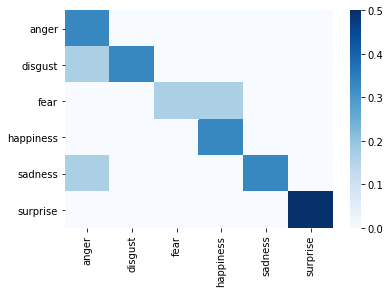

In [40]:
import seaborn as sns
sns.heatmap(df_conf_,cmap="Blues")

## Stochastic Gradient Descent

In [ ]:
#make weights and bias arrays
W = np.zeros((num_inputs+1, num_outputs))

In [ ]:
def stochastic_class_gradient(x,y,w,iterations):
    num_samples=len(x)
    for j in range(iterations):
        for i in range(num_samples):
            rand_ind = np.random.randint(0, num_samples)
            pred
            

In [ ]:
stoch_epoch=[]
stoch_training_loss=[]
for e in range(50):
    for itera in range(0,len(projectedTrain)):
        learningRate = .11
        W=W+(learningRate*stochastic_class_gradient(projectedTrain,trainLabels,W.T,itera))
        stoch_epoch.append(e)
        stoch_training_loss.append(cost(softmax(net_input(projectedTrain,W)),trainLabels)/(len(projectedTrain)*num_outputs))

In [ ]:
df3=pd.DataFrame({"epoch":epoch,"batch":train_loss,"stochastic":stoch_training_loss[:50]})

In [ ]:
len(stoch_training_loss[:51])

In [ ]:
plt.plot( 'epoch', 'batch', data=df3, marker='', color="blue")
plt.plot( 'epoch', 'stochastic', data=df3, marker='', color="orange")
plt.ylabel("cost")
plt.xlabel("cost")
plt.legend()

In [ ]:
image_test=np.array([w[5] for w in W][1:])

In [ ]:
image_250=np.interp(image_test, (image_test.min(), image_test.max()), (0, 250))

In [ ]:
image_250